In [4]:
import configparser
import unittest
import datetime
import sys
import pandas as pd


# from tqdm import tqdm_notebook

sys.path.append("/home/sergey/drclinics/common")
from universal_connection import UniversalConnection, DBType

sys.path.append("/home/sergey/drclinics/reports")
# from report_utils import excel_report

from connect_platform import connect_telemed

import numpy as np
from log import log

In [350]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
participants = pd.read_excel('ВЭБМЕД участники опроса.xlsx')

In [62]:
participants.head()

,phone
0,79774978848
1,79209781044
2,79999080837
3,79095863136
4,79163485944


In [179]:
temp = []
for i in range(participants.shape[0]):
    temp.append(str(participants['phone'][i]))

In [180]:
# temp = []
# for i in range(5):
#     temp.append(str(participants['phone'][i]))

In [165]:
# temp

['79774978848', '79209781044', '79999080837', '79095863136', '79163485944']

In [181]:
ph = "'" + "', '".join(temp) + "'"

In [182]:
# ph

In [183]:
# params = {'phones': ", ".join(temp)}

In [184]:
# params = {'phones': '79774978848, 79209781044'}

In [185]:
# params = {'phones': '79774978848'}

In [186]:
# ph = "'79774978848', '79209781044'"

In [187]:
# params

In [188]:
sql = """
select 	per.id person_id,
		patient.id patient_id,
		concat_ws(' ', per.first_name, per.middle_name, per.last_name) patient_fio,
		per.phone,
		per.birthday,
		date_part('year', timezone('Europe/Moscow', now() - 
			(extract(hour from now())) * interval '1 hour' - 
			(extract(minute from now())) * interval '1 minute' - 
			(extract(second from now())) * interval '1 second')) - 
			date_part('year', per.birthday) age,
		per.sex,
		date(a.finished + 3 * interval '1 hour') app_finished,
		'CHAT' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_chat,
        'VIDEO' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_video,
        'AUDIO' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_audio,
        'PHONE' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_phone
from person per
inner join patient on per.id = patient.person_id 
inner join appointment a on a.patient_id = patient.id
left join promotion promo on a.promotion_id = promo.id
where a.finished at time zone 'UTC' > '2020-03-30'
and promo.description_tsvector = 'телемедицина_вэб'
and phone in ({})
and a.good
  and not (
    a.patient_id in (
        select patient_id
        from patient_categories pcat
        inner join reference rf
           on rf.id=pcat.reference_id
        where rf.code='TEST'
        )
    or lower(a.report_comment)='тест'
    )
order by patient.id
""".format(ph)
             

In [189]:
conn = connect_telemed()
df: pd.DataFrame = conn.query(sql)
conn.close()

2020-05-06 17:20:18 connect to postgres database using config file "/home/sergey/drclinics/common/../.credentials/telemed/prom.cfg"
2020-05-06 17:20:18 creating ssh tunnel to 172.16.100.19 as root...
2020-05-06 17:20:18 connect postgres using parameters:
                    database: telemed
				    user: norekhov
				    password: ***masked***
				    host: localhost
				    port: 42059
2020-05-06 17:20:18 @telemed: execute sql:
				    SET TIME ZONE 'Europe/Moscow'
				    None
2020-05-06 17:20:18 @telemed query:
                    select 	per.id person_id,
				    		patient.id patient_id,
				    		concat_ws(' ', per.first_name, per.middle_name, per.last_name) patient_fio,
				    		per.phone,
				    		per.birthday,
				    		date_part('year', timezone('Europe/Moscow', now() - 
				    			(extract(hour from now())) * interval '1 hour' - 
				    			(extract(minute from now())) * interval '1 minute' - 
				    			(extract(second from now())) * interval '1 second')) - 
				    			da

In [191]:
df.head()

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone
0,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,None,2020-04-22,False,False,True,False
1,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,None,2020-04-28,False,True,False,False
2,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,None,2020-04-29,False,True,False,False
3,7515,7220,Зульфия Альбертовна Сагундукова,79600348591,1992-04-24,28.0,FEMALE,2020-04-27,False,True,False,False
4,10362,9972,Алексей Сергеевич Поляков,79268799198,1999-09-08,21.0,MALE,2020-04-28,True,False,True,False


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7272 entries, 0 to 7271
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   person_id     7272 non-null   int64  
 1   patient_id    7272 non-null   int64  
 2   patient_fio   7272 non-null   object 
 3   phone         7272 non-null   object 
 4   birthday      7272 non-null   object 
 5   age           7272 non-null   float64
 6   sex           7272 non-null   object 
 7   app_finished  7272 non-null   object 
 8   is_chat       7272 non-null   bool   
 9   is_video      7272 non-null   bool   
 10  is_audio      7272 non-null   bool   
 11  is_phone      7272 non-null   bool   
dtypes: bool(4), float64(1), int64(2), object(5)
memory usage: 483.0+ KB


In [278]:
df.sex.unique()

array(['MALE', 'FEMALE'], dtype=object)

In [200]:
df.fillna(value='Unknown', inplace=True)

In [277]:
df[df['sex'] == 'Unknown'].groupby(['patient_id', 'patient_fio', 'sex'])['sex'].count()

Series([], Name: sex, dtype: int64)

In [16]:
pd.DataFrame(df[df['sex'] == 'Unknown'].groupby(['patient_id', 'patient_fio', 'sex'])['sex'].count()).head(25)

,,,sex
patient_id,patient_fio,sex,


In [274]:
d = {
    52452:'MALE', 84640:'FEMALE', 144261:'FEMALE', 358284:'MALE', 437315:'MALE', 468809:'FEMALE', 3091467:'FEMALE', 
    3050272:'FEMALE', 3049512:'FEMALE', 3192928:'FEMALE', 3174578:'FEMALE', 3165476:'FEMALE', 3165337:'FEMALE', 
    3048066:'MALE', 3486251:'FEMALE', 3483688:'FEMALE', 3202156:'MALE', 3201951:'FEMALE', 3193306:'FEMALE', 3047850:'FEMALE',
    3495740:'FEMALE', 3495717:'FEMALE', 3495537:'FEMALE', 3495250:'FEMALE', 3494275:'FEMALE', 3488376:'FEMALE', 
    3045906:'MALE', 3045247:'FEMALE', 3031471:'MALE', 3026541:'FEMALE', 3498675:'MALE', 3497919:'FEMALE', 3496864:'FEMALE', 
    3496642:'FEMALE', 3496582:'FEMALE', 3496503:'FEMALE', 3496143:'FEMALE', 3496059:'MALE', 3495880:'FEMALE', 3495810:'FEMALE',
    3504844:'FEMALE', 3502890:'FEMALE', 3502849:'FEMALE', 3502557:'FEMALE', 3502354:'FEMALE', 3502031:'MALE', 
    3501997:'FEMALE', 3501149:'FEMALE', 3501056:'FEMALE', 3498758:'FEMALE', 3000090:'FEMALE', 2995467:'FEMALE',
    2983494:'FEMALE', 2973433:'FEMALE', 3510604:'FEMALE', 3510515:'MALE', 3510448:'FEMALE', 3509963:'FEMALE', 3509941:'FEMALE', 
    3508716:'FEMALE', 3505395:'FEMALE', 3505541:'FEMALE', 3505595:'FEMALE', 3505622:'FEMALE', 3514809:'FEMALE', 3514733:'MALE',
    3514643:'FEMALE', 3514584:'FEMALE', 3513871:'FEMALE', 3513656:'FEMALE', 3513481:'FEMALE', 3513439:'FEMALE', 3516559:'FEMALE',
    3516382:'FEMALE', 3516158:'FEMALE', 3516071:'FEMALE', 3515017:'FEMALE', 506161:'FEMALE', 3506172:'FEMALE', 3513174:'FEMALE',
    3520987:'FEMALE', 3520741:'FEMALE', 3519365:'FEMALE', 3519123:'FEMALE', 3518869:'FEMALE', 3517044:'FEMALE', 2915315:'MALE',
    3504913:'FEMALE', 3505970:'FEMALE', 3506161:'FEMALE', 3525893:'FEMALE', 3525721:'MALE', 3525688:'FEMALE', 3525370:'FEMALE',
    3525050:'FEMALE', 3524743:'FEMALE', 3524611:'FEMALE', 3521044:'FEMALE', 3521033:'FEMALE', 3516840:'FEMALE', 3514982:'FEMALE',
    3527462:'MALE', 3527408:'FEMALE', 3527240:'FEMALE', 3527210:'FEMALE', 3527209:'MALE', 3521019:'FEMALE', 3526638:'MALE',
    3527846:'FEMALE', 3527783:'MALE', 3527763:'FEMALE', 3527712:'FEMALE', 3527663:'FEMALE', 3527648:'FEMALE', 3527034:'FEMALE',
    3528752:'FEMALE', 3528726:'FEMALE', 3528118:'MALE', 3528036:'FEMALE', 3527980:'FEMALE', 3527969:'FEMALE', 3527956:'MALE',
    3527578:'FEMALE', 3527045:'FEMALE', 3530484:'FEMALE', 3530073:'FEMALE', 3529910:'FEMALE', 3529754:'FEMALE', 3529463:'FEMALE',
    3529428:'FEMALE', 3529390:'FEMALE', 3529071:'FEMALE', 3528910:'MALE', 3526699:'FEMALE', 3531577:'FEMALE', 3530637:'FEMALE',
    3530545:'FEMALE', 3526692:'FEMALE', 3526478:'FEMALE', 3515008:'FEMALE', 3514814:'FEMALE', 3512796:'FEMALE', 2904780:'FEMALE',
    2676391:'FEMALE', 2595303:'FEMALE', 2198022:'FEMALE', 2123509:'FEMALE', 1738326:'FEMALE', 1307873:'FEMALE', 482226:'FEMALE',
    12311:'MALE', 3836:'MALE' # ANONYMOUS x2
}

In [275]:
for i in range(df.shape[0]):
    if df['patient_id'][i] in d:
        df['sex'][i] = d[df['patient_id'][i]]

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



In [279]:
df.head(15)

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone
0,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-22,False,False,True,False
1,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-28,False,True,False,False
2,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-29,False,True,False,False
3,7515,7220,Зульфия Альбертовна Сагундукова,79600348591,1992-04-24,28.0,FEMALE,2020-04-27,False,True,False,False
4,10362,9972,Алексей Сергеевич Поляков,79268799198,1999-09-08,21.0,MALE,2020-04-28,True,False,True,False
5,12701,12311,Аноним 9256 Аноним,79998231974,1970-01-01,50.0,MALE,2020-04-27,False,False,True,False
6,25992,25549,Денис Сергеевич Кунгуров,79854244014,1978-06-30,42.0,MALE,2020-04-30,False,False,False,True
7,25992,25549,Денис Сергеевич Кунгуров,79854244014,1978-06-30,42.0,MALE,2020-04-28,False,False,False,True
8,25992,25549,Денис Сергеевич Кунгуров,79854244014,1978-06-30,42.0,MALE,2020-04-22,False,False,False,True
9,25992,25549,Денис Сергеевич Кунгуров,79854244014,1978-06-30,42.0,MALE,2020-05-03,True,False,True,False


In [280]:
df['using_application'] = ''
df['using_phone'] = ''

In [285]:
for i in range(df.shape[0]):
    if df['is_phone'][i] == True:
        df['using_phone'][i] = 'Phone'
    if df['is_chat'][i] == True or df['is_video'][i] == True or df['is_audio'][i] == True:
        df['using_application'] = 'Application'

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



In [298]:
df.head()

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone,using_application,using_phone
0,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-22,False,False,True,False,Application,
1,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-28,False,True,False,False,Application,
2,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-29,False,True,False,False,Application,
3,7515,7220,Зульфия Альбертовна Сагундукова,79600348591,1992-04-24,28.0,FEMALE,2020-04-27,False,True,False,False,Application,
4,10362,9972,Алексей Сергеевич Поляков,79268799198,1999-09-08,21.0,MALE,2020-04-28,True,False,True,False,Application,


In [ ]:
# 03.05.2020

In [297]:
df['app_finished'] = df['app_finished'].apply(pd.to_datetime)

2020-05-06 18:36:07 @telemed: closing postgres connection...
2020-05-06 18:36:07 closing ssh tunnel to 172.16.100.19...
2020-05-06 18:36:07 @telemed: closing postgres connection...
2020-05-06 18:36:07 closing ssh tunnel to 172.16.100.19...


In [301]:
df[df['app_finished'] == pd.Timestamp(2020,5,3)]

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone,using_application,using_phone
9,25992,25549,Денис Сергеевич Кунгуров,79854244014,1978-06-30,42.0,MALE,2020-05-03,True,False,True,False,Application,
36,140286,130376,Лариса Анатольевна Родионова,79283573616,1972-11-14,48.0,FEMALE,2020-05-03,False,False,False,True,Application,Phone
95,2073569,2052071,Екатерина Андреевна Иванова,79218582635,1986-08-29,34.0,FEMALE,2020-05-03,False,False,True,False,Application,
101,2222306,2198022,Мария Александровна Бочарова,79210876239,1993-03-21,27.0,FEMALE,2020-05-03,False,False,False,True,Application,Phone
272,3085198,3048796,Карина Васильевна Потапнина,79013569483,1992-11-03,28.0,FEMALE,2020-05-03,True,False,False,False,Application,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,3567468,3530627,Ольга Дмитриевна Кашаева,79172047863,1985-08-27,35.0,FEMALE,2020-05-03,False,False,False,True,Application,Phone
7234,3568334,3531493,Галина Михайловна Куршакова,79212816561,1964-06-04,56.0,FEMALE,2020-05-03,False,False,True,False,Application,
7247,3568418,3531577,Галина Ивановна Гасан,79170260451,1986-09-03,34.0,FEMALE,2020-05-03,False,False,True,False,Application,
7255,3568450,3531609,Елена Сергеевна Серажетдинова,79121461777,1990-01-04,30.0,FEMALE,2020-05-03,False,False,False,True,Application,Phone


In [302]:
df[df['app_finished'] == pd.Timestamp(2020,5,3)].groupby(['patient_id', 'sex'])['phone'].count()

patient_id  sex   
25549       MALE      1
130376      FEMALE    1
2052071     FEMALE    1
2198022     FEMALE    1
3048796     FEMALE    1
                     ..
3530627     FEMALE    1
3531493     FEMALE    1
3531577     FEMALE    1
3531609     FEMALE    1
3549223     FEMALE    1
Name: phone, Length: 146, dtype: int64

### NEW_PART (2020-05-03)

In [ ]:
# patients 2020-05-03

In [303]:
len(df[df['app_finished'] == pd.Timestamp(2020,5,3)].groupby(['patient_id', 'sex'])['phone'].count())

146

In [ ]:
# total patients

In [304]:
len(df.groupby(['patient_id', 'sex'])['phone'].count())

2040

-------------------------

In [309]:
df_old = pd.DataFrame(df.groupby(['patient_id', 'sex'])['phone'].count().reset_index())

In [311]:
df_old[df_old['phone'] > 1]

,patient_id,sex,phone
0,3836,MALE,3
4,25549,MALE,8
8,67763,FEMALE,4
10,76628,MALE,2
11,84640,FEMALE,3
...,...,...,...
2021,3531555,FEMALE,2
2023,3531577,FEMALE,6
2024,3531602,MALE,5
2025,3531609,FEMALE,2


### MORE THAN 1 CONS

In [ ]:
# more than 1 consultation

In [312]:
len(df_old[df_old['phone'] > 1])

1382

In [ ]:
# total consultations

In [319]:
df_old['phone'][df_old['phone'] > 1].sum(axis=0)

6614

------------------------------

In [326]:
df_male_female = pd.DataFrame(df.groupby(['sex', 'patient_id'])['phone'].count().reset_index())

In [329]:
df_male_female.groupby('sex')['phone'].sum()

sex
FEMALE    6207
MALE      1065
Name: phone, dtype: int64

### SEX PARTITION

In [337]:
df_male_female[df_male_female['sex'] == 'FEMALE'].groupby('sex')['phone'].sum()[0]

6207

In [338]:
df_male_female[df_male_female['sex'] == 'MALE'].groupby('sex')['phone'].sum()[0]

1065

----------------------

In [339]:
df_aged = pd.DataFrame(df)

In [341]:
df_aged['age_cat'] = df_aged['age'].apply(lambda age: (age < 30 and 1) or (age < 40 and 2) or (age < 50 and 3) 
                                          or (age > 49 and 4))

In [346]:
df_aged.head()

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone,using_application,using_phone,age_cat
0,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-22,False,False,True,False,Application,,1
1,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-28,False,True,False,False,Application,,1
2,4076,3836,Анонимp4545 Анонимp4545,79852533418,2000-01-01,20.0,MALE,2020-04-29,False,True,False,False,Application,,1
3,7515,7220,Зульфия Альбертовна Сагундукова,79600348591,1992-04-24,28.0,FEMALE,2020-04-27,False,True,False,False,Application,,1
4,10362,9972,Алексей Сергеевич Поляков,79268799198,1999-09-08,21.0,MALE,2020-04-28,True,False,True,False,Application,,1


In [385]:
#fig, axes = plt.subplots(1, 4, figsize=(24, 6))
#df_aged[df_aged['age_cat'] == 1]['age'].value_counts().sort_index().plot.bar(ax=axes[0], color='green')
#axes[0].set_title("Under 30", fontsize=18)
#df_aged[df_aged['age_cat'] == 2]['age'].value_counts().sort_index().plot.bar(ax=axes[1], color='blue')
#axes[1].set_title("Under 40", fontsize=18)
#df_aged[df_aged['age_cat'] == 3]['age'].value_counts().sort_index().plot.bar(ax=axes[2], color='black')
#axes[2].set_title("Under 50", fontsize=18)
#df_aged[df_aged['age_cat'] == 4]['age'].value_counts().sort_index().plot.bar(ax=axes[3], color='black')
#axes[3].set_title("Over 50", fontsize=18)


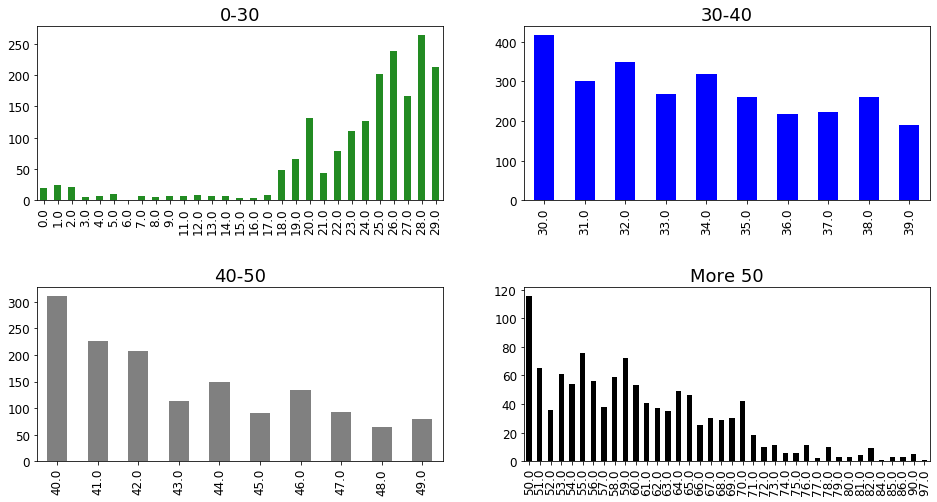

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

df_aged[df_aged['age_cat'] == 1]['age'].value_counts().sort_index().plot.bar(
    ax=axes[0][0], fontsize=12, color='forestgreen'
)
axes[0][0].set_title("0-30", fontsize=18)

df_aged[df_aged['age_cat'] == 2]['age'].value_counts().sort_index().plot.bar(
    ax=axes[0][1], fontsize=12, color='blue'
)
axes[0][1].set_title("30-40", fontsize=18)

df_aged[df_aged['age_cat'] == 3]['age'].value_counts().sort_index().plot.bar(
    ax=axes[1][0], fontsize=12, color='gray'
)
axes[1][0].set_title("40-50", fontsize=18)

df_aged[df_aged['age_cat'] == 4]['age'].value_counts().sort_index().plot.bar(
    ax=axes[1][1], fontsize=12, color='black'
)
axes[1][1].set_title("More 50", fontsize=18)
    
plt.subplots_adjust(hspace=.5)

# FAST RABBIT

In [1]:
import configparser
import unittest
import datetime
import sys
import pandas as pd


# from tqdm import tqdm_notebook

sys.path.append("/home/sergey/drclinics/common")
from universal_connection import UniversalConnection, DBType

sys.path.append("/home/sergey/drclinics/reports")
# from report_utils import excel_report

from connect_platform import connect_telemed

import numpy as np
from log import log

In [2]:
participants = pd.read_excel('ВЭБМЕД участники опроса.xlsx')

In [4]:
temp_ph = []
for i in range(participants.shape[0]):
    temp_ph.append(str(participants['phone'][i]))

In [5]:
ph = "'" + "', '".join(temp_ph) + "'"

In [7]:
regions_dict = {
                'Алтайский край':'Алтайский край',
                'Амурская обл.':'Амурская область',
                'Архангельская обл.':'Архангельская область',
                'Архангельская область и Ненецкий автономный округ':'Архангельская область',
                'Астраханская обл.':'Астраханская область',
                'Белгородская обл.':'Белгородская область',
                'Брянская обл.':'Брянская область',
                'Владимирская обл.':'Владимирская область',
                'Волгоградская обл.':'Волгоградская область',
                'Волгоградская область':'Волгоградская область',
                'Вологодская обл.':'Вологодская область',
                'Воронежская обл.':'Воронежская область',
                'Воронежская область':'Воронежская область',
                'г. Владимир|Владимирская обл.':'Владимирская область',
                'г. Кострома|р-н Костромской|Костромская обл.':'Костромская область',
                'г. Москва и Московская область':'Москва и Московская область',
                'г. Норильск|Красноярский край':'Красноярский край',
                'г. Псков|Псковская обл.':'Псковская область',
                'г. Санкт - Петербург и Ленинградская область':'Санкт-Петербург',
                'г. Санкт-Петербург и Ленинградская область':'Санкт-Петербург',
                'г. Севастополь':'Севастополь',
                'г. Сочи|Краснодарский край':'Краснодарский край',
                'Еврейская автономная обл.':'Еврейская автономная область',
                'Забайкальский край':'Забайкальский край',
                'Ивановская обл.':'Ивановская область',
                'Иркутская обл.':'Иркутская область',
                'Иркутская область':'Иркутская область',
                'Кабардино-Балкарская Республика':'Кабардино-Балкарская Республика',
                'Калининградская обл.':'Калининградская область',
                'Калужская обл.':'Калужская область',
                'Камчатский край':'Камчатский край',
                'Карачаево-Черкесская Республика':'Карачаево-Черкесская Республика',
                'Кемеровская обл.':'Кемеровская область',
                'Кировская обл.':'Кировская область',
                'Корякский округ|Камчатский край':'Камчатский край',
                'Костромская обл.':'Костромская область',
                'Краснодарский край':'Краснодарский край',
                'Красноярский край':'Красноярский край',
                'Курганская обл.':'Курганская область',
                'Курская обл.':'Курская область',
                'Липецкая обл.':'Липецкая область',
                'Магаданская обл.':'Магаданская область',
                'Мурманская обл.':'Мурманская область',
                'Ненецкий АО':'Ненецкий автономный округ',
                'Нижегородская обл.':'Нижегородская область',
                'Новгородская обл.':'Новгородская область',
                'Новосибирская обл.':'Новосибирская область',
                'Омская обл.':'Омская область',
                'Оренбургская обл.':'Оренбургская область',
                'Орловская обл.':'Орловская область',
                'Пензенская обл.':'Пензенская область',
                'Пермский край':'Пермский край',
                'Приморский край':'Приморский край',
                'Псковская обл.':'Псковская область',
                'р-ны Абзелиловский и Белорецкий|р-ны Абзелиловский и Белорецкий':'Республика Башкортостан',
                'Республика Адыгея':'Республика Адыгея',
                'Республика Алтай':'Республика Алтай',
                'Республика Башкортостан':'Республика Башкортостан',
                'Республика Бурятия':'Республика Бурятия',
                'Республика Дагестан':'Республика Дагестан',
                'Республика Ингушетия':'Республика Ингушетия',
                'Республика Кабардино-Балкарская':'Кабардино-Балкарская Республика',
                'Республика Калмыкия':'Республика Калмыкия',
                'Республика Карачаево-Черкесская':'Карачаево-Черкесская Республика',
                'Республика Карелия':'Республика Карелия',
                'Республика Коми':'Республика Коми',
                'Республика Крым':'Республика Крым',
                'Республика Крым и г. Севастополь':'Севастополь',
                'Республика Марий Эл':'Республика Марий Эл',
                'Республика Мордовия':'Республика Мордовия',
                'Республика Саха /Якутия/':'Республика Саха Якутия',
                'Республика Северная Осетия - Алания':'Республика Северная Осетия — Алания',
                'Республика Татарстан':'Республика Татарстан',
                'Республика Тыва':'Республика Тыва',
                'Республика Удмуртская':'Удмуртская Республика',
                'Республика Хакасия':'Республика Хакасия',
                'Российская Федерация':'Неизвестный регион',
                'Ростовская обл.':'Ростовская область',
                'Ростовская область':'Ростовская область',
                'Рязанская обл.':'Рязанская область',
                'Самарская обл.':'Самарская область',
                'Самарская область':'Самарская область',
                'Саратовская обл.':'Саратовская область',
                'Сахалинская обл.':'Сахалинская область',
                'Свердловская обл.':'Свердловская область',
                'Свердловская область':'Свердловская область',
                'Смоленская обл.':'Смоленская область',
                'Смоленская область':'Смоленская область',
                'Ставропольский край':'Ставропольский край',
                'Сургутский район и г. Сургут':'Ханты-Мансийский автономный округ',
                'Тамбовская обл.':'Тамбовская область',
                'Тверская обл.':'Тверская область',
                'Томская обл.':'Томская область',
                'Томская область':'Томская область',
                'Тульская обл.':'Тульская область',
                'Тюменская обл.':'Тюменская область',
                'Тюменская область':'Тюменская область',
                'Удмуртская Республика':'Удмуртская Республика',
                'Ульяновская обл.':'Ульяновская область',
                'Хабаровский край':'Хабаровский край',
                'Ханты - Мансийский - Югра АО':'Ханты-Мансийский автономный округ',
                'Челябинская обл.':'Челябинская область',
                'Челябинская область':'Челябинская область',
                'Чеченская Республика':'Чеченская Республика',
                'Чувашская Республика':'Чувашская Республика',
                'Чувашская Республика - Чувашия':'Чувашская Республика',
                'Чукотский АО':'Чукотский автономный округ',
                'Ямало-Ненецкий АО':'Ямало-Ненецкий автономный округ',
                'Ярославская обл.':'Ярославская область',
                'Москва':'Москва и Московская область',
                'Московская область':'Москва и Московская область',
                'Алматы':'Алматы',
                'Брестская область':'Брестская область',
                'Витебская область':'Витебская область',
                'Восточно-Казахстанская область':'Восточно-Казахстанская область',
                'город республиканского значения Нур-Султан':'город республиканского значения Нур-Султан',
                'Донецкая область':'Донецкая область',
                'Ереван':'Ереван',
                'Ленинградская область':'Санкт-Петербург',
                'Минск':'Минск',
                'Минская область':'Минская область',
                'муниципалитет Тбилиси':'муниципалитет Тбилиси',
                'Северо-Западный федеральный округ':'Санкт-Петербург',
                'Северо-Казахстанская область':'Северо-Казахстанская область',
                'Центральный федеральный округ':'Москва и Московская область',
                'Киев':'Киев',
                'Magnesia ad Sipylum':'Неизвестный регион',
                'Wattala':'Неизвестный регион',
                'автономное сообщество Андалусия':'Неизвестный регион',
                'автономное сообщество Валенсия':'Неизвестный регион',
                'Англия':'Неизвестный регион',
                'Анкара':'Неизвестный регион',
                'Анталья':'Неизвестный регион',
                'Армавирская область':'Неизвестный регион',
                'Атырауская область':'Неизвестный регион',
                'Берлин':'Неизвестный регион',
                'Будапешт':'Неизвестный регион',
                'Бурса':'Неизвестный регион',
                'Вена':'Неизвестный регион',
                'Вестра-Гёталанд':'Неизвестный регион',
                'Виктория':'Неизвестный регион',
                'Гессен':'Неизвестный регион',
                'Джорджия':'Неизвестный регион',
                'Иль-де-Франс':'Неизвестный регион',
                'Истарская жупания':'Неизвестный регион',
                'Калифорния':'Неизвестный регион',
                'Каталония':'Неизвестный регион',
                'Кыршехир':'Неизвестный регион',
                'Ломбардия':'Неизвестный регион',
                'Мангистауская область':'Неизвестный регион',
                'Марыйский велаят':'Неизвестный регион',
                'Норд-Брабант':'Неизвестный регион',
                'Норд-Холланд':'Неизвестный регион',
                'область Варна':'Неизвестный регион',
                'префектура Токио':'Неизвестный регион',
                'Прованс-Альпы-Лазурный Берег':'Неизвестный регион',
                'провинция Бали':'Неизвестный регион',
                'провинция Кханьхоа':'Неизвестный регион',
                'провинция Онтарио':'Неизвестный регион',
                'Пусан':'Неизвестный регион',
                'Пхукет':'Неизвестный регион',
                'Северный Рейн-Вестфалия':'Неизвестный регион',
                'Стокгольм':'Неизвестный регион',
                'столичный регион Брюссель':'Неизвестный регион',
                'Сулия':'Неизвестный регион',
                'Тоскана':'Неизвестный регион',
                'Утрехт':'Неизвестный регион',
                'Уусимаа':'Неизвестный регион',
                'Цюрих':'Неизвестный регион',
                'штат Мэриленд':'Неизвестный регион',
                'штат Нью-Йорк':'Неизвестный регион',
                'штат Флорида':'Неизвестный регион',
                'эмират Дубай':'Неизвестный регион',
                'эмират Рас-эль-Хайма':'Неизвестный регион'
}

In [8]:
def phone_base():
    base = pd.read_csv('DEF.csv')
    
    column_base = ['code', 'start', 'end', 'capacity', 'operator', 'region']
    base.columns = column_base
    
    return base

In [9]:
def phone_base_nikita():
    base = pd.read_csv('phone_city_map.csv')
    
    column_base = ['idx', 'phone', 'region']
    base['phone'] = base['phone'].astype(str)
    base.columns = column_base
    base['clean_region'] = ''
    
    for i in range(base.shape[0]):
        temp = base['region'][i].replace('(', '').replace(')', '').replace("'"," ")
        temp = list(temp.split(','))
        for j in range(len(temp)):
            temp[j] = temp[j].strip()
            
        temp = [x for x in temp if x]
        if not temp:
            temp = ['Заглушка','Неизвестный регион']
        elif len(temp) == 1:
            temp.insert(0, 'Заглушка')
        
        base['clean_region'][i] = temp
    
    return base

In [10]:
def get_region_by_two_bases(phone, base=phone_base(), base_n=phone_base_nikita()):
    if type(phone) != str:
        phone = str(phone)
    phone = ''.join(i for i in phone if i.isdigit())    
    if phone[0] == '8':
        phone = '7'+ phone[1:]
    if len(phone) != 11:
        return 'Неизвестный регион'
    
    try:
        return base_n.loc[(base_n['phone'] == phone)]['clean_region'].to_list()[0][1]
    except:
        return base.loc[(base['code'] == int(phone[1:4])) &
                    (base['start'] <= int(phone[4:])) &
                    (base['end'] >= int(phone[4:]))
                    ]['region'].to_string(index=False).strip()

/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
def clean_region(region, dictionary=regions_dict):
    if region in dictionary:
        return dictionary[region]
    return 'Неизвестный регион'

In [12]:
sql = """
select 	per.id person_id,
		patient.id patient_id,
		concat_ws(' ', per.first_name, per.middle_name, per.last_name) patient_fio,
		per.phone,
		per.birthday,
		date_part('year', timezone('Europe/Moscow', now() - 
			(extract(hour from now())) * interval '1 hour' - 
			(extract(minute from now())) * interval '1 minute' - 
			(extract(second from now())) * interval '1 second')) - 
			date_part('year', per.birthday) age,
		per.sex,
		date(a.finished + 3 * interval '1 hour') app_finished,
		'CHAT' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_chat,
        'VIDEO' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_video,
        'AUDIO' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_audio,
        'PHONE' in (
            select reference.code
            from appointment_connection_type
    		left join reference on reference.id = appointment_connection_type.reference_id
    		where a.id = appointment_connection_type.appointment_id
    		) as is_phone
from person per
inner join patient on per.id = patient.person_id 
inner join appointment a on a.patient_id = patient.id
left join promotion promo on a.promotion_id = promo.id
where a.finished at time zone 'UTC' > '2020-03-30'
and promo.description_tsvector = 'телемедицина_вэб'
and phone in ({})
and a.good
  and not (
    a.patient_id in (
        select patient_id
        from patient_categories pcat
        inner join reference rf
           on rf.id=pcat.reference_id
        where rf.code='TEST'
        )
    or lower(a.report_comment)='тест'
    )
order by patient.id
""".format(ph)

In [13]:
conn = connect_telemed()
df: pd.DataFrame = conn.query(sql)
conn.close()

2020-05-07 12:09:23 connect to postgres database using config file "/home/sergey/drclinics/common/../.credentials/telemed/prom.cfg"
2020-05-07 12:09:23 creating ssh tunnel to 172.16.100.19 as root...
2020-05-07 12:09:24 connect postgres using parameters:
                    database: telemed
				    user: norekhov
				    password: ***masked***
				    host: localhost
				    port: 37827
2020-05-07 12:09:24 @telemed: execute sql:
				    SET TIME ZONE 'Europe/Moscow'
				    None
2020-05-07 12:09:24 @telemed query:
                    select 	per.id person_id,
				    		patient.id patient_id,
				    		concat_ws(' ', per.first_name, per.middle_name, per.last_name) patient_fio,
				    		per.phone,
				    		per.birthday,
				    		date_part('year', timezone('Europe/Moscow', now() - 
				    			(extract(hour from now())) * interval '1 hour' - 
				    			(extract(minute from now())) * interval '1 minute' - 
				    			(extract(second from now())) * interval '1 second')) - 
				    			da

In [14]:
d = {
    52452:'MALE', 84640:'FEMALE', 144261:'FEMALE', 358284:'MALE', 437315:'MALE', 468809:'FEMALE', 3091467:'FEMALE', 
    3050272:'FEMALE', 3049512:'FEMALE', 3192928:'FEMALE', 3174578:'FEMALE', 3165476:'FEMALE', 3165337:'FEMALE', 
    3048066:'MALE', 3486251:'FEMALE', 3483688:'FEMALE', 3202156:'MALE', 3201951:'FEMALE', 3193306:'FEMALE', 3047850:'FEMALE',
    3495740:'FEMALE', 3495717:'FEMALE', 3495537:'FEMALE', 3495250:'FEMALE', 3494275:'FEMALE', 3488376:'FEMALE', 
    3045906:'MALE', 3045247:'FEMALE', 3031471:'MALE', 3026541:'FEMALE', 3498675:'MALE', 3497919:'FEMALE', 3496864:'FEMALE', 
    3496642:'FEMALE', 3496582:'FEMALE', 3496503:'FEMALE', 3496143:'FEMALE', 3496059:'MALE', 3495880:'FEMALE', 3495810:'FEMALE',
    3504844:'FEMALE', 3502890:'FEMALE', 3502849:'FEMALE', 3502557:'FEMALE', 3502354:'FEMALE', 3502031:'MALE', 
    3501997:'FEMALE', 3501149:'FEMALE', 3501056:'FEMALE', 3498758:'FEMALE', 3000090:'FEMALE', 2995467:'FEMALE',
    2983494:'FEMALE', 2973433:'FEMALE', 3510604:'FEMALE', 3510515:'MALE', 3510448:'FEMALE', 3509963:'FEMALE', 3509941:'FEMALE', 
    3508716:'FEMALE', 3505395:'FEMALE', 3505541:'FEMALE', 3505595:'FEMALE', 3505622:'FEMALE', 3514809:'FEMALE', 3514733:'MALE',
    3514643:'FEMALE', 3514584:'FEMALE', 3513871:'FEMALE', 3513656:'FEMALE', 3513481:'FEMALE', 3513439:'FEMALE', 3516559:'FEMALE',
    3516382:'FEMALE', 3516158:'FEMALE', 3516071:'FEMALE', 3515017:'FEMALE', 506161:'FEMALE', 3506172:'FEMALE', 3513174:'FEMALE',
    3520987:'FEMALE', 3520741:'FEMALE', 3519365:'FEMALE', 3519123:'FEMALE', 3518869:'FEMALE', 3517044:'FEMALE', 2915315:'MALE',
    3504913:'FEMALE', 3505970:'FEMALE', 3506161:'FEMALE', 3525893:'FEMALE', 3525721:'MALE', 3525688:'FEMALE', 3525370:'FEMALE',
    3525050:'FEMALE', 3524743:'FEMALE', 3524611:'FEMALE', 3521044:'FEMALE', 3521033:'FEMALE', 3516840:'FEMALE', 3514982:'FEMALE',
    3527462:'MALE', 3527408:'FEMALE', 3527240:'FEMALE', 3527210:'FEMALE', 3527209:'MALE', 3521019:'FEMALE', 3526638:'MALE',
    3527846:'FEMALE', 3527783:'MALE', 3527763:'FEMALE', 3527712:'FEMALE', 3527663:'FEMALE', 3527648:'FEMALE', 3527034:'FEMALE',
    3528752:'FEMALE', 3528726:'FEMALE', 3528118:'MALE', 3528036:'FEMALE', 3527980:'FEMALE', 3527969:'FEMALE', 3527956:'MALE',
    3527578:'FEMALE', 3527045:'FEMALE', 3530484:'FEMALE', 3530073:'FEMALE', 3529910:'FEMALE', 3529754:'FEMALE', 3529463:'FEMALE',
    3529428:'FEMALE', 3529390:'FEMALE', 3529071:'FEMALE', 3528910:'MALE', 3526699:'FEMALE', 3531577:'FEMALE', 3530637:'FEMALE',
    3530545:'FEMALE', 3526692:'FEMALE', 3526478:'FEMALE', 3515008:'FEMALE', 3514814:'FEMALE', 3512796:'FEMALE', 2904780:'FEMALE',
    2676391:'FEMALE', 2595303:'FEMALE', 2198022:'FEMALE', 2123509:'FEMALE', 1738326:'FEMALE', 1307873:'FEMALE', 482226:'FEMALE',
    12311:'MALE', 3836:'MALE' # ANONYMOUS x2
}

In [19]:
df['app_finished'] = df['app_finished'].apply(pd.to_datetime)

In [15]:
for i in range(df.shape[0]):
    if df['patient_id'][i] in d:
        df['sex'][i] = d[df['patient_id'][i]]

In [140]:
df['using_application'] = ''
df['using_phone'] = ''

In [141]:
for i in range(df.shape[0]):
    if df['is_phone'][i] == True:
        df['using_phone'][i] = 'Phone'
    if df['is_chat'][i] == True or df['is_video'][i] == True or df['is_audio'][i] == True:
        df['using_application'] = 'Application'


In [21]:
df['age_cat'] = df['age'].apply(lambda age: (age < 30 and 1) or (age < 40 and 2) or (age < 50 and 3) 
                                          or (age > 49 and 4))
# 1 - < 30
# 2 - 30-40
# 3 - 40-50
# 4 - 50+

In [22]:
df['dirty_region'] = df['phone'].apply(get_region_by_two_bases)
df = df.replace('Series([], )', 'Неизвестный регион')
df['region'] = df['dirty_region'].apply(clean_region)

### Data has been completed!

In [142]:
df.tail(5)

,person_id,patient_id,patient_fio,phone,birthday,age,sex,app_finished,is_chat,is_video,is_audio,is_phone,using_application,using_phone,age_cat,dirty_region,region
7334,3571577,3534722,Галина Владимировна Синельникова,79619301291,1969-07-08,51.0,FEMALE,2020-04-30,False,False,False,True,Application,Phone,4,Оренбургская обл.,Оренбургская область
7335,3578229,3541352,оксана николаевна макарова,79192088900,1982-11-30,38.0,FEMALE,2020-04-30,False,False,False,True,Application,Phone,2,Орловская обл.,Орловская область
7336,3586101,3549223,Мария Ивановна Вершинина,79195818448,1949-11-02,71.0,FEMALE,2020-05-03,False,False,False,True,Application,Phone,4,Курганская обл.,Курганская область
7337,3588471,3551593,Юлия Станиславовна Каляева,79177789315,1982-01-01,38.0,FEMALE,2020-05-06,False,False,True,False,Application,,2,Республика Башкортостан,Республика Башкортостан
7338,3588471,3551593,Юлия Станиславовна Каляева,79177789315,1982-01-01,38.0,FEMALE,2020-05-04,False,False,False,True,Application,Phone,2,Республика Башкортостан,Республика Башкортостан


In [135]:
df['is_chat'][7334] == True or df['is_video'][7334] == True or df['is_audio'][7334] == True

False

In [133]:
df['is_audio'][7334]

False

In [61]:
#### ДОЛЯ НОВЫХ

In [56]:
# patients 2020-05-03
patients_2020_05_03 = len(df[df['app_finished'] == pd.Timestamp(2020,5,3)].groupby(['patient_id'])['phone'].count())
len(df[df['app_finished'] == pd.Timestamp(2020,5,3)].groupby(['patient_id'])['phone'].count())

146

In [57]:
# total patients (from excel-file)
total_patients = len(df.groupby(['patient_id'])['phone'].count())
len(df.groupby(['patient_id'])['phone'].count())

2038

In [58]:
round(patients_2020_05_03 * 100 / total_patients, 2)

7.16

In [62]:
##### ДОЛЯ СТАРЫХ

In [67]:
# patients with more than 1 consultation
patients_old = len(df.groupby(['patient_id'])['phone'].count()[df.groupby(['patient_id'])['phone'].count() > 1])
len(df.groupby(['patient_id'])['phone'].count()[df.groupby(['patient_id'])['phone'].count() > 1])

1384

In [69]:
# total consultations for patients with more than 1 consultation
patients_old_consultations = pd.DataFrame(df.groupby(['patient_id'])['phone'].count()[df.groupby(['patient_id'])['phone'].count() > 1]).reset_index()['phone'].sum()
pd.DataFrame(df.groupby(['patient_id'])['phone'].count()[df.groupby(['patient_id'])['phone'].count() > 1]).reset_index()['phone'].sum()

6685

In [64]:
round(patients_old * 100 / total_patients, 2)

67.91

In [71]:
round(patients_old_consultations / patients_old, 2)

4.83

In [65]:
#### ПОЛ ПРОЦЕНТОВКА

In [42]:
df.groupby(['sex'])['phone'].count()

sex
FEMALE    6255
MALE      1084
Name: phone, dtype: int64

In [88]:
# FEMALE
female = pd.DataFrame(df[df['sex'] == 'FEMALE'].groupby('patient_id')['phone'].count().reset_index())['phone'].count()
pd.DataFrame(df[df['sex'] == 'FEMALE'].groupby('patient_id')['phone'].count().reset_index())['phone'].count()

1672

In [89]:
# MALE
male = pd.DataFrame(df[df['sex'] == 'MALE'].groupby('patient_id')['phone'].count().reset_index())['phone'].count()
pd.DataFrame(df[df['sex'] == 'MALE'].groupby('patient_id')['phone'].count().reset_index())['phone'].count()

366

In [108]:
per_women = round(female/total_patients, 2)
per_women

0.82

In [109]:
per_men = round(male/total_patients, 2)
per_men

0.18

In [122]:
### КАТЕГОРИИ ПО ВОЗРАСТАМ

In [98]:
pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()

age_cat
1    546
2    737
3    373
4    382
Name: patient_id, dtype: int64

In [103]:
# below 30
pat_b30 = pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[1]
pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[1]

546

In [104]:
# 30-40
pat_30_40 = pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[2]
pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[2]

737

In [105]:
# 40-50
pat_40_50 = pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[3]
pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[3]

373

In [106]:
# 50+
pat_a50 = pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[4]
pd.DataFrame(df.groupby(['patient_id', 'age_cat'])['phone'].count().reset_index()).groupby('age_cat')['patient_id'].count()[4]

382

In [115]:
per_pat_b30 = round(pat_b30 / total_patients * 100, 2)
per_pat_b30

26.79

In [119]:
per_pat_30_40 = round(pat_30_40 / total_patients * 100, 2)
per_pat_30_40

36.16

In [120]:
per_pat_40_50 = round(pat_40_50 / total_patients * 100, 2)
per_pat_40_50

18.3

In [121]:
per_pat_a50 = round(pat_a50 / total_patients * 100, 2)
per_pat_a50

18.74

In [123]:
df.to_excel('WEB-report22.xls', index=False)